### Stock Market Prediction And Forecasting Using Stacked LSTM

In [143]:
# LIBRERIAS

import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.metrics import mean_squared_error


print(tf.__version__)

2.6.0


In [144]:
# LEEMOS CADA UNO DE LOS FICHEROS GENERADOS

companies = {}
ficheros = os.listdir('data')
for file in ficheros:
    company = file[:-4]
    dfcompany = pd.read_csv(f"data/{file}")
    companies[company] = dfcompany




In [145]:
# Tomamos datos de amazon para pruebas con el modelo.
dfcompany = companies['AMZN']
dfcompany

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AMZN,2017-04-24 00:00:00+00:00,907.41,909.990,903.8200,908.68,3118123,907.41,909.990,903.8200,908.68,3118123,0.0,1.0
1,AMZN,2017-04-25 00:00:00+00:00,907.62,909.480,903.0000,907.04,3367734,907.62,909.480,903.0000,907.04,3367734,0.0,1.0
2,AMZN,2017-04-26 00:00:00+00:00,909.29,915.749,907.5600,910.30,2562595,909.29,915.749,907.5600,910.30,2562595,0.0,1.0
3,AMZN,2017-04-27 00:00:00+00:00,918.38,921.860,912.1100,914.39,4255693,918.38,921.860,912.1100,914.39,4255693,0.0,1.0
4,AMZN,2017-04-28 00:00:00+00:00,924.99,949.590,924.3335,948.83,7278819,924.99,949.590,924.3335,948.83,7278819,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,AMZN,2022-04-14 00:00:00+00:00,3034.13,3117.940,3029.4350,3107.80,2579907,3034.13,3117.940,3029.4350,3107.80,2579907,0.0,1.0
1255,AMZN,2022-04-18 00:00:00+00:00,3055.70,3080.790,3005.0100,3030.47,2325676,3055.70,3080.790,3005.0100,3030.47,2325676,0.0,1.0
1256,AMZN,2022-04-19 00:00:00+00:00,3162.31,3172.980,3031.0100,3040.59,2746321,3162.31,3172.980,3031.0100,3040.59,2746321,0.0,1.0
1257,AMZN,2022-04-20 00:00:00+00:00,3079.96,3152.050,3072.0700,3152.05,2958600,3079.96,3152.050,3072.0700,3152.05,2958600,0.0,1.0


In [146]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

def graficar(dfcompany, company):
	plt.plot(dfcompany)
	plt.xlabel('Days')
	plt.ylabel('Price')
	plt.title(label=company)
	

def preprocesar(dfcompany):
	# PREPROCESAMIENTO DE LOS DATOS
	
	# Reescalado de los datos
	scaler=MinMaxScaler(feature_range=(0,1))
	dfcompany=scaler.fit_transform(np.array(dfcompany).reshape(-1,1))
	
	return dfcompany

# fix random seed for reproducibility
np.random.seed(42)

In [147]:
def split(dfcompany, look_back):
    # PREPARACIÓN DE DATOS DE TEST Y TRAIN
    # Disponemos de aprox 1250 días de información. Queremos dejar el último mes para test.
    # Fijaremos como datos de entrenamiento el 65% del los datos disponibles
    training_size = int(len(dfcompany)*0.65)
    test_size = len(dfcompany)-training_size

    train_data, test_data = dfcompany[0:training_size,:], dfcompany[training_size:len(dfcompany),:1]

    print(f"El total de datos es {len(dfcompany)}")
    print(f"Nº datos entrenamiento = {training_size}")
    print(f"Nº datos test = {test_size}")
    print(np.shape(train_data))
    print(np.shape(test_data))

    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    
    X_train, y_train = create_dataset(train_data, look_back)
    X_test, y_test = create_dataset(test_data, look_back)
    print(X_train.shape), print(y_train.shape)

    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    return X_train, X_test, y_train, y_test



In [148]:
def entrenar(X_train, X_test, y_train, y_test ):
    ### Create the Stacked LSTM model
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(look_back,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    model.summary()

    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

    return model

In [149]:
def prediccion (model, X_train, X_test, y_train, y_test):
    # Lets Do the prediction and check performance metrics
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)

    # Transformback to original form
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)

    # Calculate RMSE performance metrics
    trainError = math.sqrt(mean_squared_error(y_train,train_predict))

    # Test Data RMSE
    testError = math.sqrt(mean_squared_error(y_test,test_predict))

    ytestreversed = scaler.inverse_transform(y_test.reshape(-1,1))
    ytestreversed[-5:]

    test_predict[-5:]

    ### Plotting 
    # shift train predictions for plotting
    look_back=100
    trainPredictPlot = np.empty_like(dfcompany)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dfcompany)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dfcompany)-1, :] = test_predict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dfcompany))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.legend(['Original data', 'Prediction train output', 'Predicted test output' ])
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()


    plt.plot(testPredictPlot)
    plt.title('Test prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()


El total de datos es 1259
Nº datos entrenamiento = 818
Nº datos test = 441
(818, 1)
(441, 1)
(717, 100)
(717,)


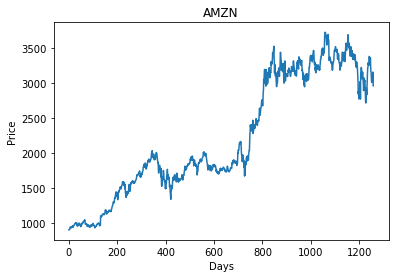

In [150]:
look_back = 100
# Por cada empresa, preprocesar, entrenar y guardar resultados

company = dfcompany.iloc[0,0]
# Descartamos todas las columnas y nos quedamos unicamente con el precio de cierre de la acción
dfcompany=dfcompany.reset_index()['close']
graficar(dfcompany, company)
dfcompany = preprocesar(dfcompany)
X_train, X_test, y_train, y_test = split(dfcompany, look_back)



In [151]:
model = entrenar(X_train, X_test, y_train, y_test )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12/12 [==============================] - 20s 561ms/step - loss: 0.0330 - val_loss: 0.0910
Epoch 2/10
12/12 [==============================] - 4s 315ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 3/10
12/12 [=============================

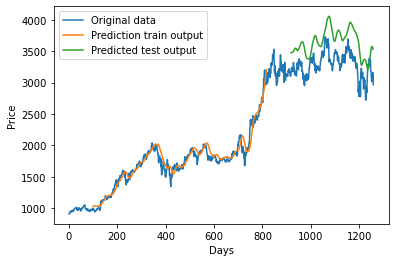

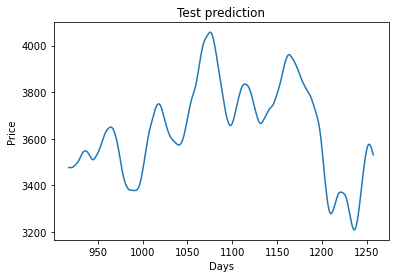

In [152]:
prediccion(model, X_train, X_test, y_train, y_test)